In [1]:
%matplotlib inline
from sklearn.datasets import load_iris
from  scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import random, sys
import matplotlib.pyplot as plt
from scipy import ndimage
import cPickle as pickle
import scipy.io.wavfile as wav
from pylab import plt
from scipy.signal import butter, lfilter, freqz
from sklearn.cross_validation import train_test_split
from librosa.util import normalize
import kmeans as km
import learnvocabulary as lv

/Users/apple/anaconda/lib/python2.7/site-packages/librosa/core/audio.py:37: UserWarning: Could not import scikits.samplerate. Falling back to scipy.signal
  warnings.warn('Could not import scikits.samplerate. '


# Run kmean++ on Music data
* Import Data
* Use function learnvocabulary to get the centroids, representing the words
* Use function getbof to vectorize the counts per song


X size/number of songs: 40
Number of clips per song: 10
y size: 40
----- Running kmeans++ -----
After MFCC X.shape (30, 10, 12, 130)
X_train_flattened.shape (300, 12, 130)
After transpose X_train_flattened.shape (300, 130, 12)


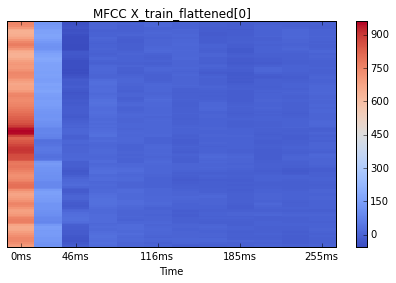

X_train_flattened_norm_final.shape (39000, 12)
Start kmeans


KeyboardInterrupt: 

In [2]:
X, y = lv.getData()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2010)
print '-----', 'Running kmeans++', '-----'
centroids = lv.learnvocabulary(X_train, 20, "kpp", 100, True) #X, k, clusterMethod, Iter, transpose
print 'Number of centroids:', len(centroids)

# print '-----', 'Running kmeans_multi', '-----'
# cen_t = lv.learnvocabulary(X_train, 20, "multi", 100, True)
# print 'Number of centroids:', len(cen_t)


# Feed to TF-idf
* Used new training data to vectorize BOF from previously computed centroids
* Import X_train_bofCounts into tfidf_transformer

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
# X_train, y_train = lv.getData()
X_train_bofCounts, y_train_bofCounts = lv.getbof(X_train, y_train, centroids)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_bofCounts)
print "X_train_tfidf.shape", X_train_tfidf.shape
y_train = np.array(y_train)
print "y_train.shape", y_train.shape

getbof X.shape (300, 12, 130)
X_train_tfidf.shape (300, 20)
y_train.shape (30,)


# Train classifier
* Use KNeighborsClassifier as our classifier

In [6]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

param_grid = {'n_neighbors': np.arange(3, 10),'weights':('uniform', 'distance'), 'algorithm':('auto','ball_tree', 'kd_tree', 'brute') }
np.set_printoptions(suppress=True)
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=3)

grid_search.fit(X_train_tfidf, y_train_bofCounts)

Fitting 3 folds for each of 56 candidates, totalling 168 fits
[CV] n_neighbors=3, weights=uniform, algorithm=auto ..................
[CV]  n_neighbors=3, weights=uniform, algorithm=auto, score=0.250000 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=auto ..................
[CV]  n_neighbors=3, weights=uniform, algorithm=auto, score=0.222222 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=auto ..................
[CV]  n_neighbors=3, weights=uniform, algorithm=auto, score=0.237113 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=auto .................
[CV]  n_neighbors=3, weights=distance, algorithm=auto, score=0.269231 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=auto .................
[CV]  n_neighbors=3, weights=distance, algorithm=auto, score=0.212121 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=auto .................
[CV]  n_neighbors=3, weights=distance, algorithm=auto, score=0.247423 -   0.0s
[CV] n_neighbors=4, weights=uniform, algo

[Parallel(n_jobs=1)]: Done  31 tasks       | elapsed:    0.2s
/Users/apple/anaconda/lib/python2.7/site-packages/sklearn/neighbors/base.py:229: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



[CV] n_neighbors=9, weights=distance, algorithm=auto .................
[CV]  n_neighbors=9, weights=distance, algorithm=auto, score=0.181818 -   0.0s
[CV] n_neighbors=9, weights=distance, algorithm=auto .................
[CV]  n_neighbors=9, weights=distance, algorithm=auto, score=0.278351 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=ball_tree .............
[CV]  n_neighbors=3, weights=uniform, algorithm=ball_tree, score=0.250000 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=ball_tree .............
[CV]  n_neighbors=3, weights=uniform, algorithm=ball_tree, score=0.222222 -   0.0s
[CV] n_neighbors=3, weights=uniform, algorithm=ball_tree .............
[CV]  n_neighbors=3, weights=uniform, algorithm=ball_tree, score=0.237113 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=ball_tree ............
[CV]  n_neighbors=3, weights=distance, algorithm=ball_tree, score=0.269231 -   0.0s
[CV] n_neighbors=3, weights=distance, algorithm=ball_tree ............
[CV]  n_nei

[Parallel(n_jobs=1)]: Done 127 tasks       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    1.2s finished



[CV] n_neighbors=8, weights=distance, algorithm=brute ................
[CV]  n_neighbors=8, weights=distance, algorithm=brute, score=0.268041 -   0.0s
[CV] n_neighbors=9, weights=uniform, algorithm=brute .................
[CV]  n_neighbors=9, weights=uniform, algorithm=brute, score=0.259615 -   0.0s
[CV] n_neighbors=9, weights=uniform, algorithm=brute .................
[CV]  n_neighbors=9, weights=uniform, algorithm=brute, score=0.191919 -   0.0s
[CV] n_neighbors=9, weights=uniform, algorithm=brute .................
[CV]  n_neighbors=9, weights=uniform, algorithm=brute, score=0.226804 -   0.0s
[CV] n_neighbors=9, weights=distance, algorithm=brute ................
[CV]  n_neighbors=9, weights=distance, algorithm=brute, score=0.317308 -   0.0s
[CV] n_neighbors=9, weights=distance, algorithm=brute ................
[CV]  n_neighbors=9, weights=distance, algorithm=brute, score=0.181818 -   0.0s
[CV] n_neighbors=9, weights=distance, algorithm=brute ................
[CV]  n_neighbors=9, weig

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([3, 4, 5, 6, 7, 8, 9]), 'weights': ('uniform', 'distance'), 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

# Predict test data

getbof X.shape (100, 12, 130)
0.06
{'n_neighbors': 6, 'weights': 'distance', 'algorithm': 'auto'}
(56,)
(7, 8)
[ 0.23666667  0.24333333  0.28333333  0.3         0.27333333  0.30333333
  0.28        0.30666667]


<matplotlib.colorbar.Colorbar instance at 0x110076680>

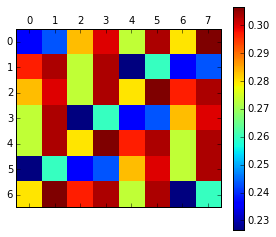

In [10]:
X_test_bofCounts, y_test_bofCounts = lv.getbof(X_test, y_test, centroids)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_bofCounts)

predict = grid_search.predict(X_test_bofCounts)
print grid_search.score(X_test_bofCounts, y_test_bofCounts)
print grid_search.best_params_

# We extract just the scores
scores = [x.mean_validation_score for x in grid_search.grid_scores_]
print np.array(scores).shape
scores = np.array(scores).reshape(7, 8)
print scores.shape
print scores[0]
plt.matshow(scores)
plt.colorbar()
# plt.xticks(np.arange(5), param_grid['gamma'])
# plt.yticks(np.arange(6), param_grid['C']);